In [6]:
from IPython.display import clear_output
warnings.filterwarnings("ignore")
import warnings
import random
import cv2
import os
from matplotlib import pyplot as plt
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'
clear_output()

In [7]:
class MyTrainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator(dataset_name, cfg, False, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1, COCOEvaluatorHook(
            self.cfg.DATASETS.TEST[0],
            self.cfg,
            True,
            self.model,
            self.optimizer,
            self.scheduler
        ))
        return hooks

class COCOEvaluatorHook(HookBase):
    def __init__(self, dataset_name, cfg, is_final, model, optimizer, scheduler):
        self._dataset_name = dataset_name
        self._cfg = cfg
        self._is_final = is_final
        self._model = model
        self._optimizer = optimizer
        self._scheduler = scheduler
        self._best_metric = -1

    def after_step(self):
        self.trainer.storage.put_scalar('learning_rate', self._optimizer.param_groups[0]["lr"], smoothing_hint=False)
        if self.trainer.iter % self._cfg.TEST.EVAL_PERIOD == 0 or self._is_final:
            self.trainer.model.eval()
            results = inference_on_dataset(self._model, build_detection_test_loader(self._cfg, self._dataset_name), COCOEvaluator(self._dataset_name, self._cfg, True))
            self.trainer.model.train()
            if results['bbox']['AP'] > self._best_metric:
                self._best_metric = results['bbox']['AP']
                # Here you can implement saving the best model
            else:
                # Stop training if metric hasn't improved
                raise EarlyStoppingException()

class EarlyStoppingException(Exception):
    pass


In [9]:
register_coco_instances("my_dataset_train", {}, "./train/_annotations.coco.json", "./train")
register_coco_instances("my_dataset_val", {}, "./valid/_annotations.coco.json", "./valid")

In [10]:
# Set up the logger
setup_logger()

# Configuration setup
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.DEVICE = "cpu"

# Set up data augmentation
cfg.INPUT.MIN_SIZE_TRAIN = (640, 672, 704, 736, 768, 800)
cfg.INPUT.MAX_SIZE_TRAIN = 1333
cfg.INPUT.MIN_SIZE_TEST = 800
cfg.INPUT.MAX_SIZE_TEST = 1333
cfg.INPUT.CROP.ENABLED = True
cfg.INPUT.CROP.TYPE = "relative_range"
cfg.INPUT.CROP.SIZE = [0.9, 0.9]
cfg.INPUT.RANDOM_FLIP = "horizontal"

# Set up learning rate scheduler
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.GAMMA = 0.05

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/30 12:01:48 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [04/30 12:01:48 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/30 12:01:48 d2.data.datasets.coco]: Loaded 1695 images in COCO format from ./train/_annotations.coco.json
[04/30 12:01:48 d2.data.build]: Removed 0 images with no usable annotations. 1695 images left.
[04/30 12:01:48 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| tumor-vR5S | 0            |   Glioma   | 583          | Meningioma | 359          |
|  No Tumor  | 335          | Pituitary  | 440          |            |              |
|   total    | 1717         |            |              |            |              |
[04/30 12:01:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [RandomCrop(crop_type='relative_range', crop_size=[0.9, 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[04/30 12:01:48 d2.engine.train_loop]: Starting training from iteration 0
[04/30 12:02:45 d2.utils.events]:  eta: 1:05:02  iter: 19  total_loss: 1.735  loss_cls: 1.407  loss_box_reg: 0.2641  loss_rpn_cls: 0.04274  loss_rpn_loc: 0.007092    time: 2.6465  last_time: 2.8303  data_time: 0.1300  last_data_time: 0.0008   lr: 3.8962e-06  


Using TensorFlow backend.


[04/30 12:03:39 d2.utils.events]:  eta: 1:03:22  iter: 39  total_loss: 1.657  loss_cls: 1.321  loss_box_reg: 0.2736  loss_rpn_cls: 0.05165  loss_rpn_loc: 0.009011    time: 2.5804  last_time: 2.3598  data_time: 0.0009  last_data_time: 0.0008   lr: 7.8922e-06  
[04/30 12:04:28 d2.utils.events]:  eta: 1:01:46  iter: 59  total_loss: 1.37  loss_cls: 1.095  loss_box_reg: 0.2559  loss_rpn_cls: 0.03954  loss_rpn_loc: 0.006617    time: 2.5347  last_time: 2.5906  data_time: 0.0009  last_data_time: 0.0010   lr: 1.1888e-05  
[04/30 12:05:20 d2.utils.events]:  eta: 1:01:26  iter: 79  total_loss: 1.198  loss_cls: 0.8568  loss_box_reg: 0.3161  loss_rpn_cls: 0.02958  loss_rpn_loc: 0.007644    time: 2.5588  last_time: 2.8974  data_time: 0.0010  last_data_time: 0.0008   lr: 1.5884e-05  
[04/30 12:06:10 d2.utils.events]:  eta: 0:59:54  iter: 99  total_loss: 0.8655  loss_cls: 0.5851  loss_box_reg: 0.1869  loss_rpn_cls: 0.03415  loss_rpn_loc: 0.007626    time: 2.5405  last_time: 2.5268  data_time: 0.0009  

[04/30 12:28:23 d2.utils.events]:  eta: 0:34:13  iter: 659  total_loss: 0.5823  loss_cls: 0.2054  loss_box_reg: 0.3134  loss_rpn_cls: 0.01558  loss_rpn_loc: 0.007342    time: 2.4048  last_time: 2.4573  data_time: 0.0009  last_data_time: 0.0015   lr: 0.0001  
[04/30 12:29:11 d2.utils.events]:  eta: 0:33:25  iter: 679  total_loss: 0.5727  loss_cls: 0.2042  loss_box_reg: 0.3164  loss_rpn_cls: 0.009036  loss_rpn_loc: 0.006066    time: 2.4047  last_time: 2.5146  data_time: 0.0009  last_data_time: 0.0007   lr: 0.0001  
[04/30 12:29:59 d2.utils.events]:  eta: 0:32:35  iter: 699  total_loss: 0.6347  loss_cls: 0.2364  loss_box_reg: 0.3021  loss_rpn_cls: 0.006084  loss_rpn_loc: 0.006103    time: 2.4038  last_time: 2.2302  data_time: 0.0009  last_data_time: 0.0011   lr: 0.0001  
[04/30 12:30:45 d2.utils.events]:  eta: 0:31:44  iter: 719  total_loss: 0.541  loss_cls: 0.1847  loss_box_reg: 0.3292  loss_rpn_cls: 0.007815  loss_rpn_loc: 0.006705    time: 2.4013  last_time: 2.3562  data_time: 0.0008  

[04/30 12:52:52 d2.utils.events]:  eta: 0:08:42  iter: 1279  total_loss: 0.3382  loss_cls: 0.09421  loss_box_reg: 0.224  loss_rpn_cls: 0.003737  loss_rpn_loc: 0.004803    time: 2.3876  last_time: 2.5277  data_time: 0.0009  last_data_time: 0.0007   lr: 0.0001  
[04/30 12:53:41 d2.utils.events]:  eta: 0:07:55  iter: 1299  total_loss: 0.2871  loss_cls: 0.1118  loss_box_reg: 0.1763  loss_rpn_cls: 0.005733  loss_rpn_loc: 0.005237    time: 2.3882  last_time: 2.5680  data_time: 0.0009  last_data_time: 0.0007   lr: 0.0001  
[04/30 12:54:30 d2.utils.events]:  eta: 0:07:08  iter: 1319  total_loss: 0.4308  loss_cls: 0.119  loss_box_reg: 0.2616  loss_rpn_cls: 0.00312  loss_rpn_loc: 0.006016    time: 2.3894  last_time: 2.7135  data_time: 0.0009  last_data_time: 0.0007   lr: 0.0001  
[04/30 12:55:17 d2.utils.events]:  eta: 0:06:21  iter: 1339  total_loss: 0.3855  loss_cls: 0.1316  loss_box_reg: 0.2617  loss_rpn_cls: 0.002067  loss_rpn_loc: 0.005096    time: 2.3892  last_time: 2.6274  data_time: 0.00

In [11]:
# Evaluation with COCO Evaluator
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [04/30 13:06:29 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/30 13:06:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/30 13:06:29 d2.data.datasets.coco]: Loaded 502 images in COCO format from ./valid/_annotations.coco.json
[04/30 13:06:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/30 13:06:29 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/30 13:06:29 d2.data.common]: Serializing 502 elements to byte tensors and concatenating them all ...
[04/30 13:06:29 d2.data.common]: Serialized dataset takes 0.13 MiB
[04/30 13:06:29 d2.evaluation.evaluator]: Start inference on 502 batches
[04/30 13:06:39 d2.evaluation.evaluator]:

[04/30 13:10:03 d2.evaluation.evaluator]: Inference done 342/502. Dataloading: 0.0005 s/iter. Inference: 0.6161 s/iter. Eval: 0.0001 s/iter. Total: 0.6168 s/iter. ETA=0:01:38
[04/30 13:10:08 d2.evaluation.evaluator]: Inference done 350/502. Dataloading: 0.0005 s/iter. Inference: 0.6171 s/iter. Eval: 0.0001 s/iter. Total: 0.6178 s/iter. ETA=0:01:33
[04/30 13:10:13 d2.evaluation.evaluator]: Inference done 358/502. Dataloading: 0.0005 s/iter. Inference: 0.6176 s/iter. Eval: 0.0001 s/iter. Total: 0.6184 s/iter. ETA=0:01:29
[04/30 13:10:19 d2.evaluation.evaluator]: Inference done 367/502. Dataloading: 0.0005 s/iter. Inference: 0.6175 s/iter. Eval: 0.0001 s/iter. Total: 0.6182 s/iter. ETA=0:01:23
[04/30 13:10:24 d2.evaluation.evaluator]: Inference done 376/502. Dataloading: 0.0005 s/iter. Inference: 0.6173 s/iter. Eval: 0.0001 s/iter. Total: 0.6180 s/iter. ETA=0:01:17
[04/30 13:10:30 d2.evaluation.evaluator]: Inference done 384/502. Dataloading: 0.0005 s/iter. Inference: 0.6179 s/iter. Eval:

OrderedDict([('bbox',
              {'AP': 28.048240264333028,
               'AP50': 51.96899688097465,
               'AP75': 28.5677814219819,
               'APs': nan,
               'APm': 15.41474100672358,
               'APl': 32.41018464718293,
               'AP-tumor-vR5S': nan,
               'AP-Glioma': 24.313421895352043,
               'AP-Meningioma': 41.749898996052046,
               'AP-No Tumor': 46.12964016592803,
               'AP-Pituitary': 0.0})])

[04/30 13:13:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
WARNING [04/30 13:13:01 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/30 13:13:01 d2.data.datasets.coco]: Loaded 502 images in COCO format from ./valid/_annotations.coco.json


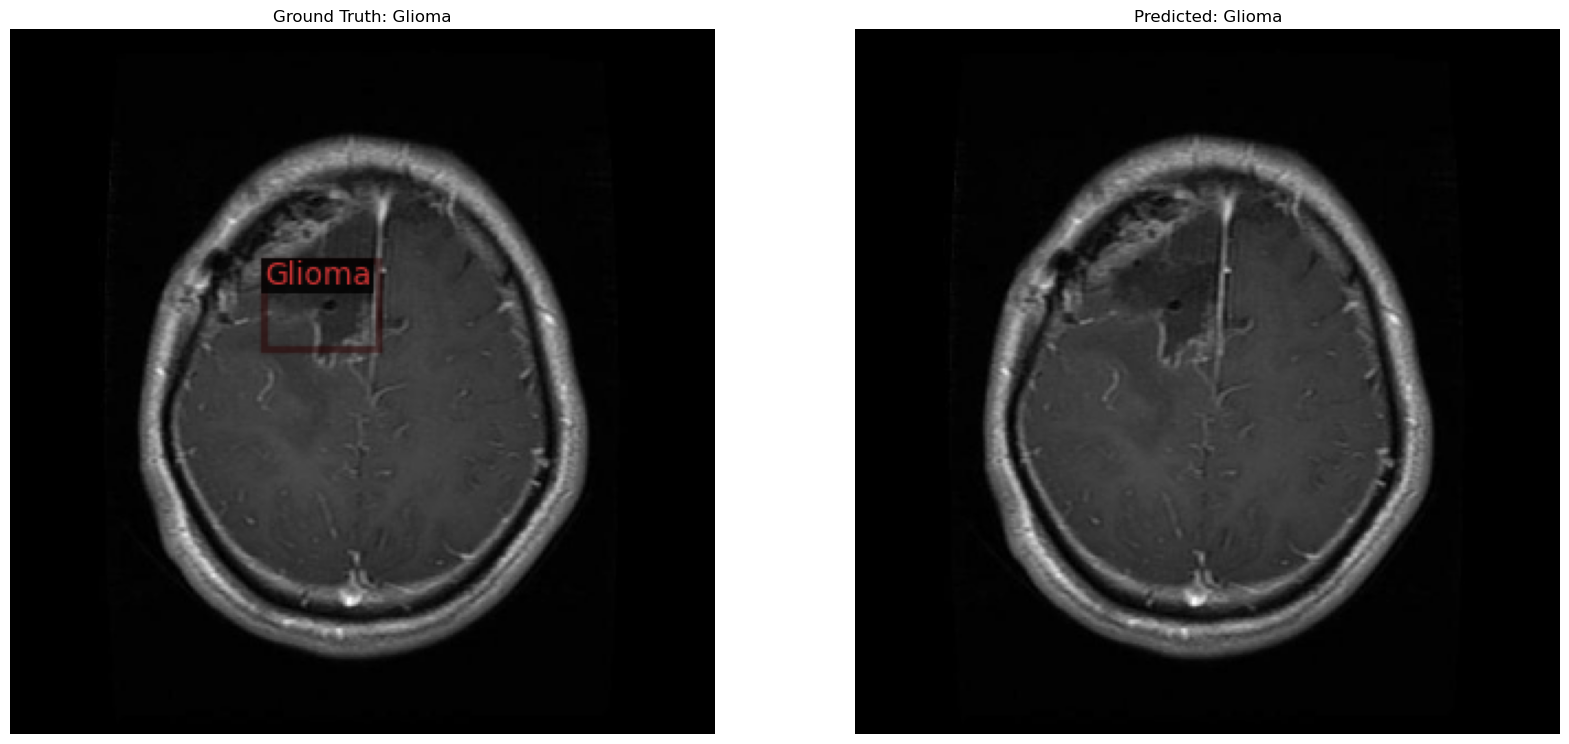

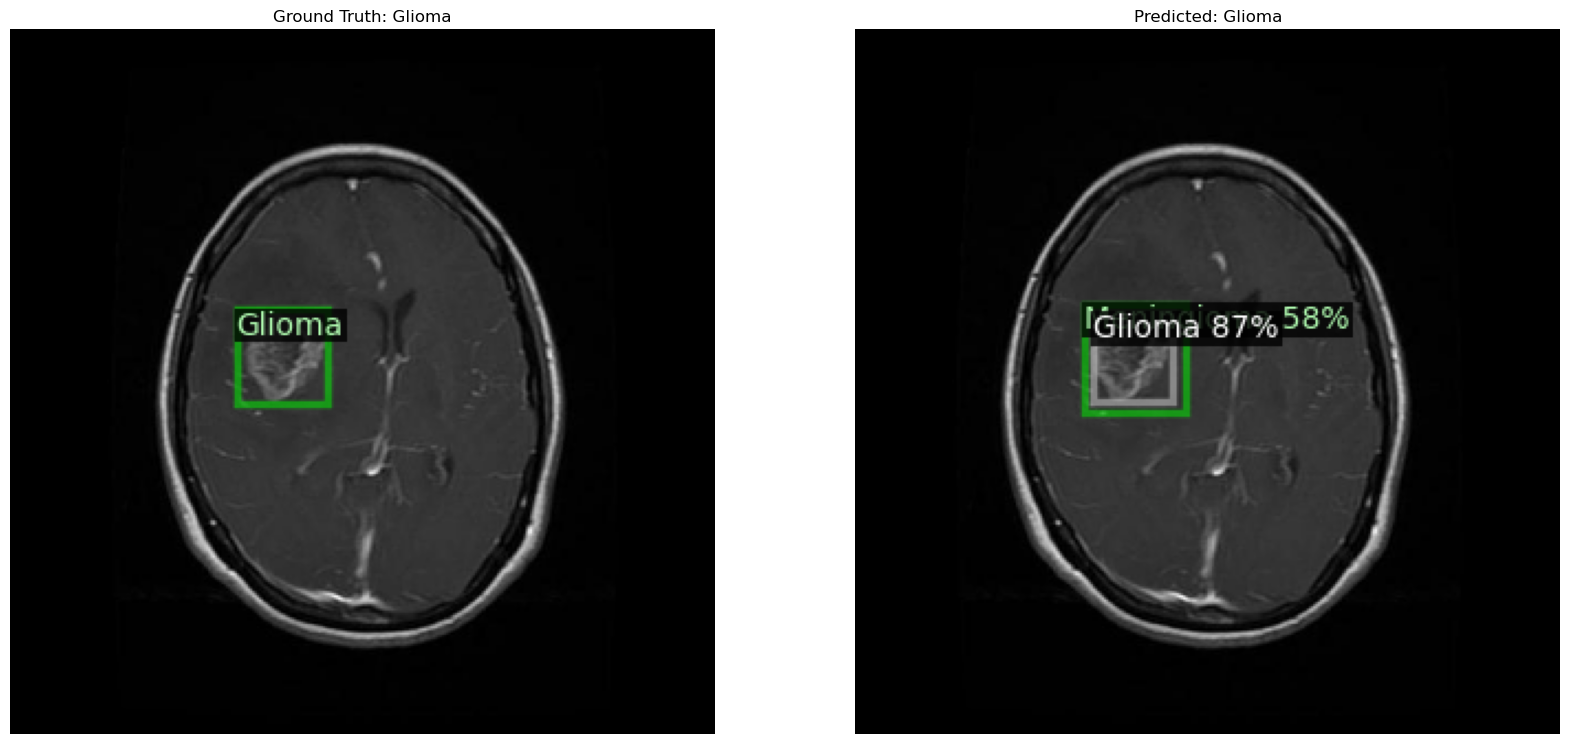

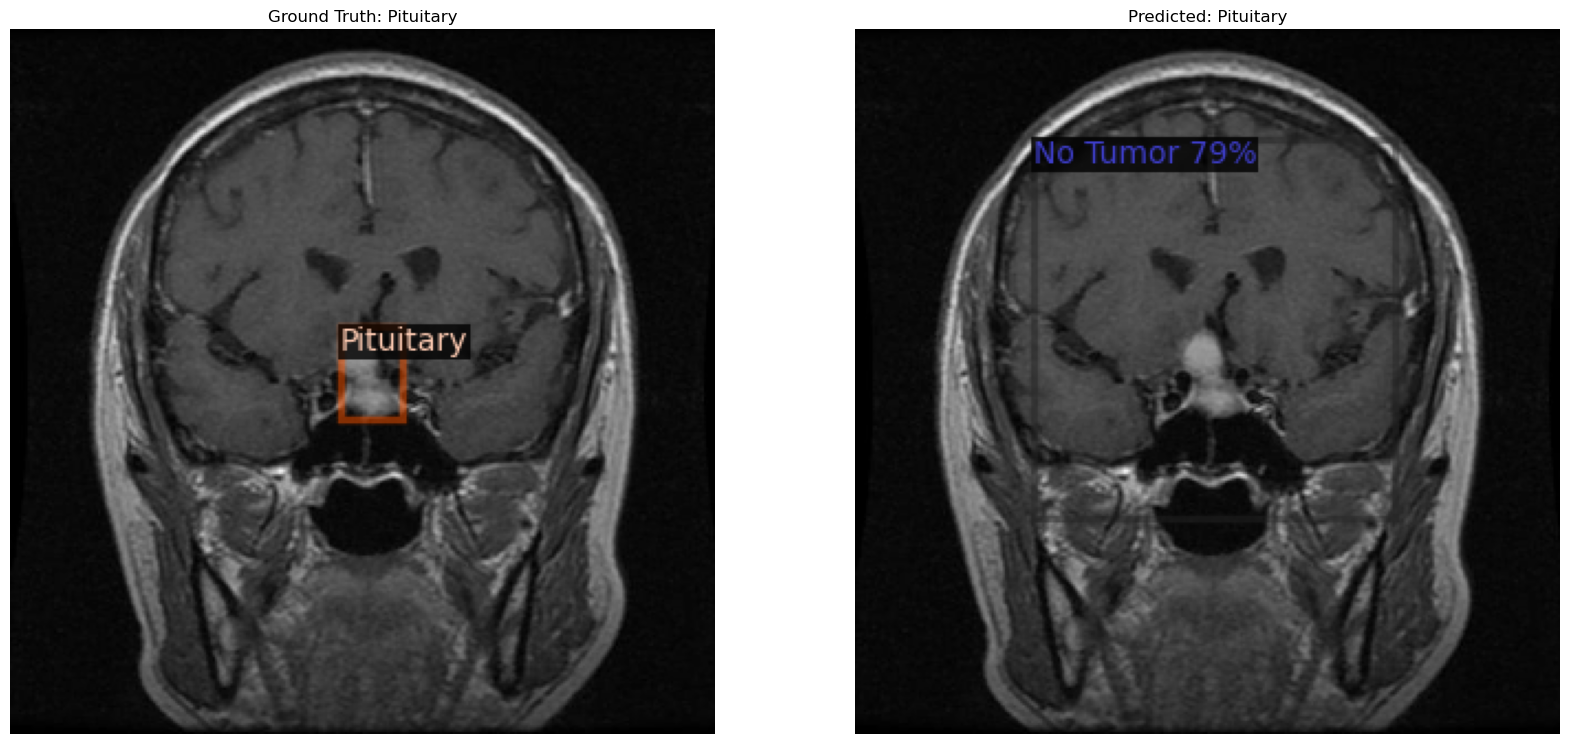

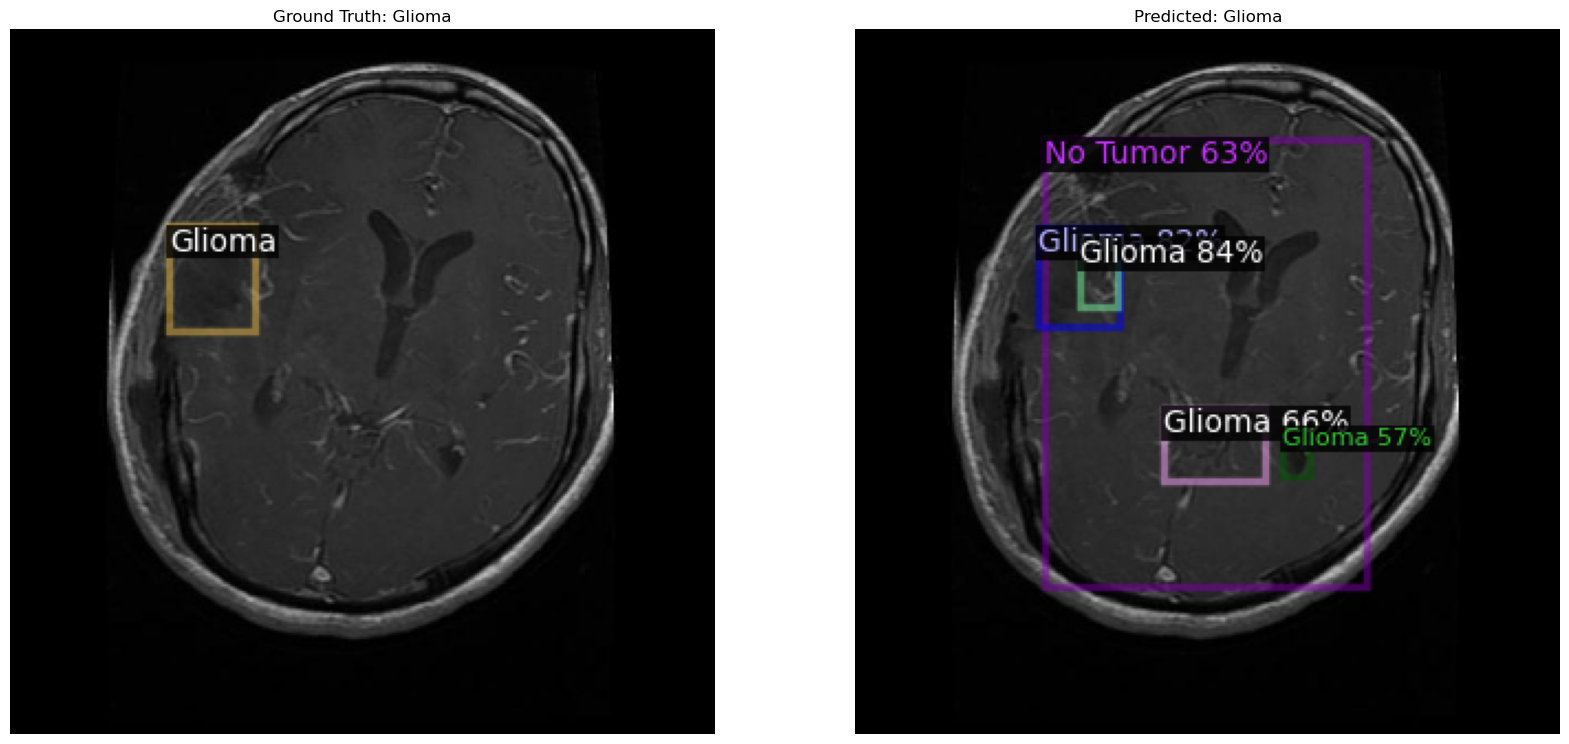

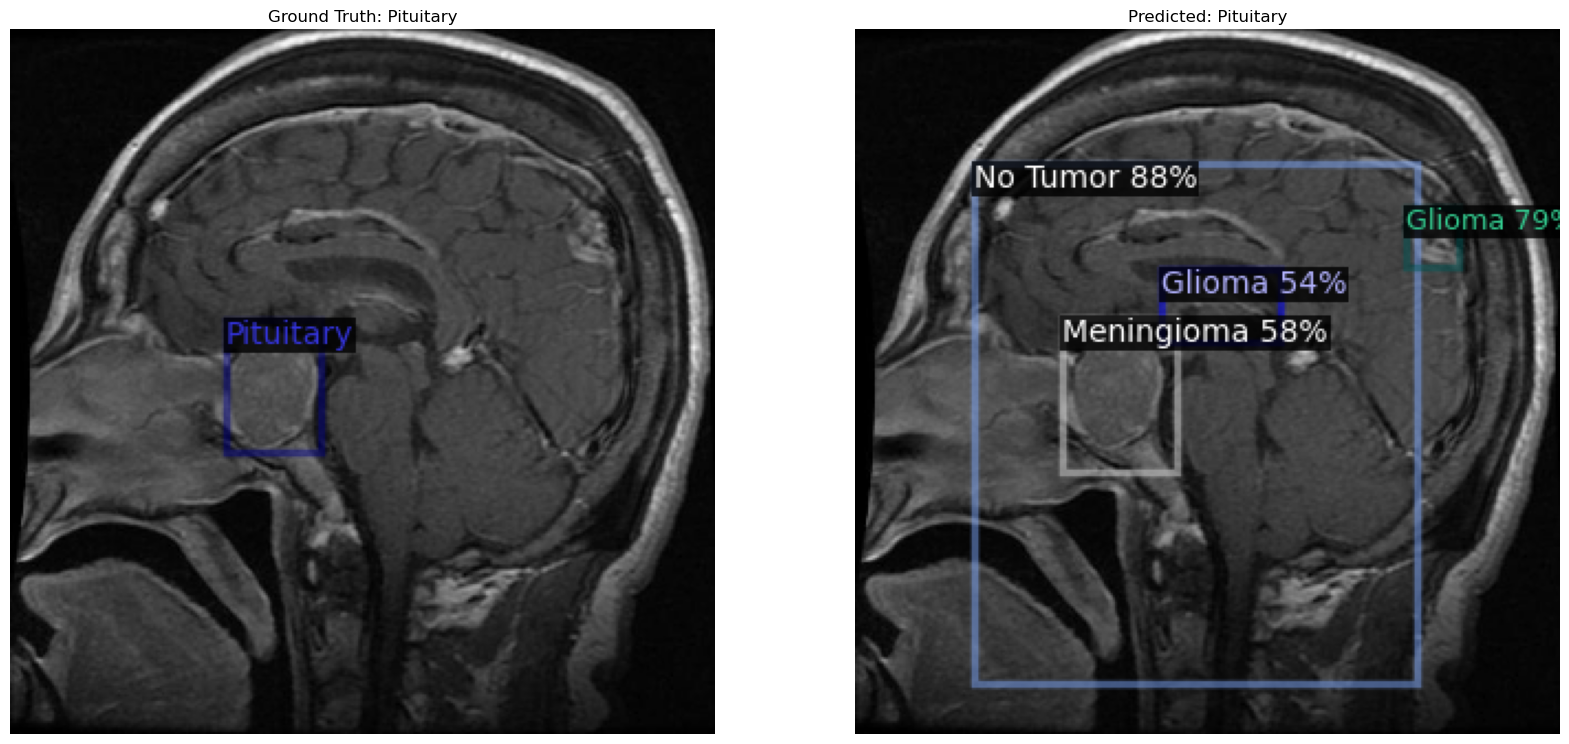

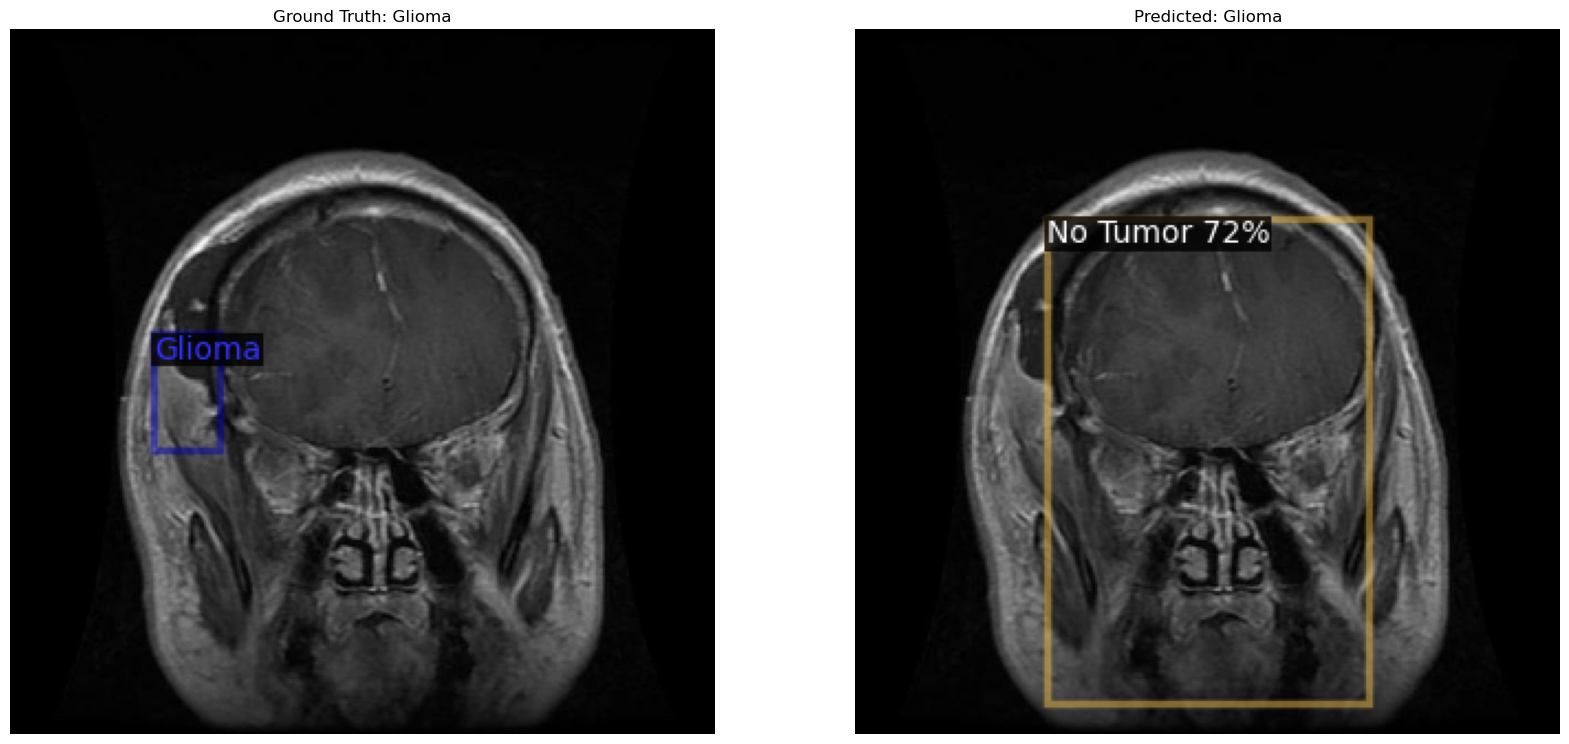

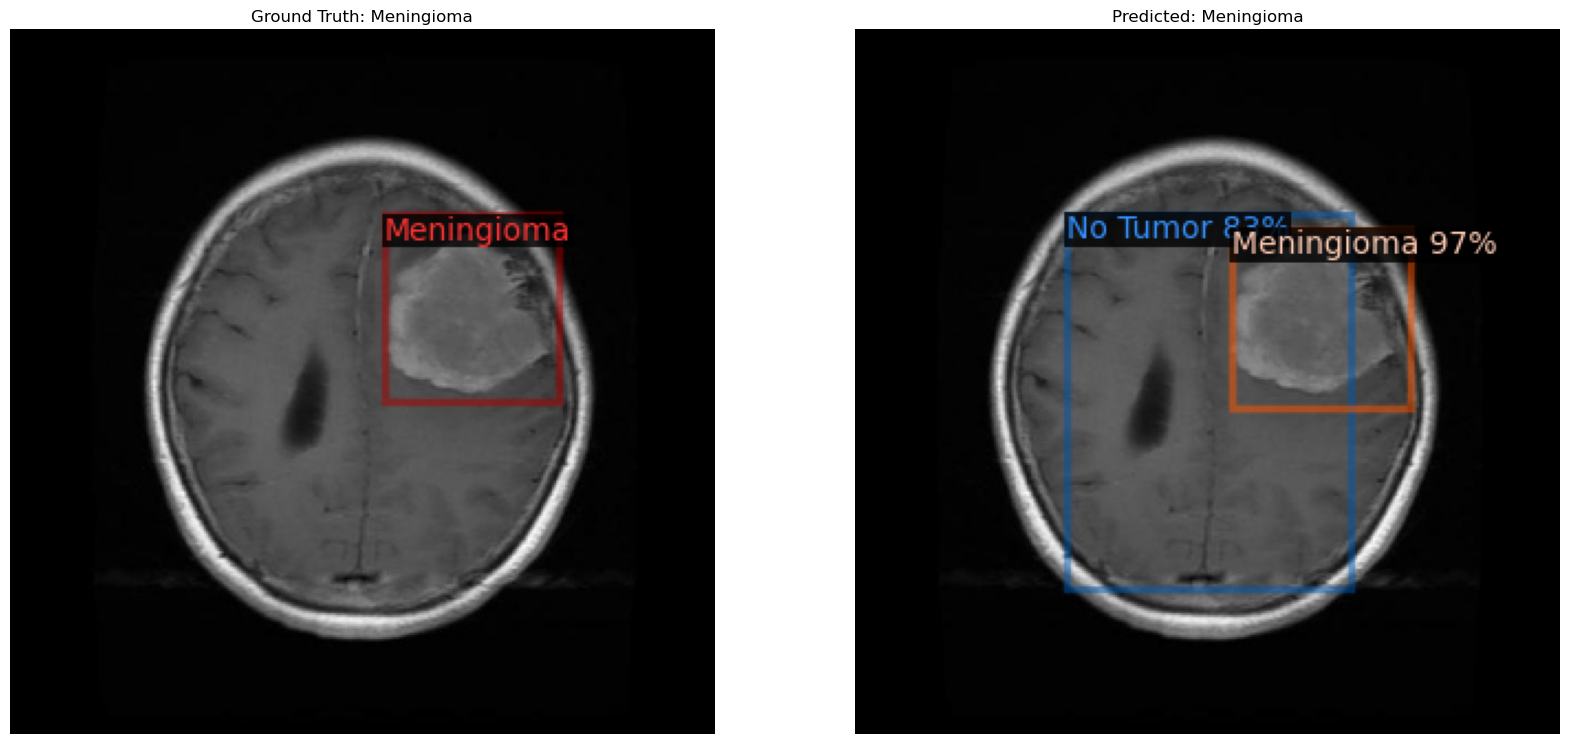

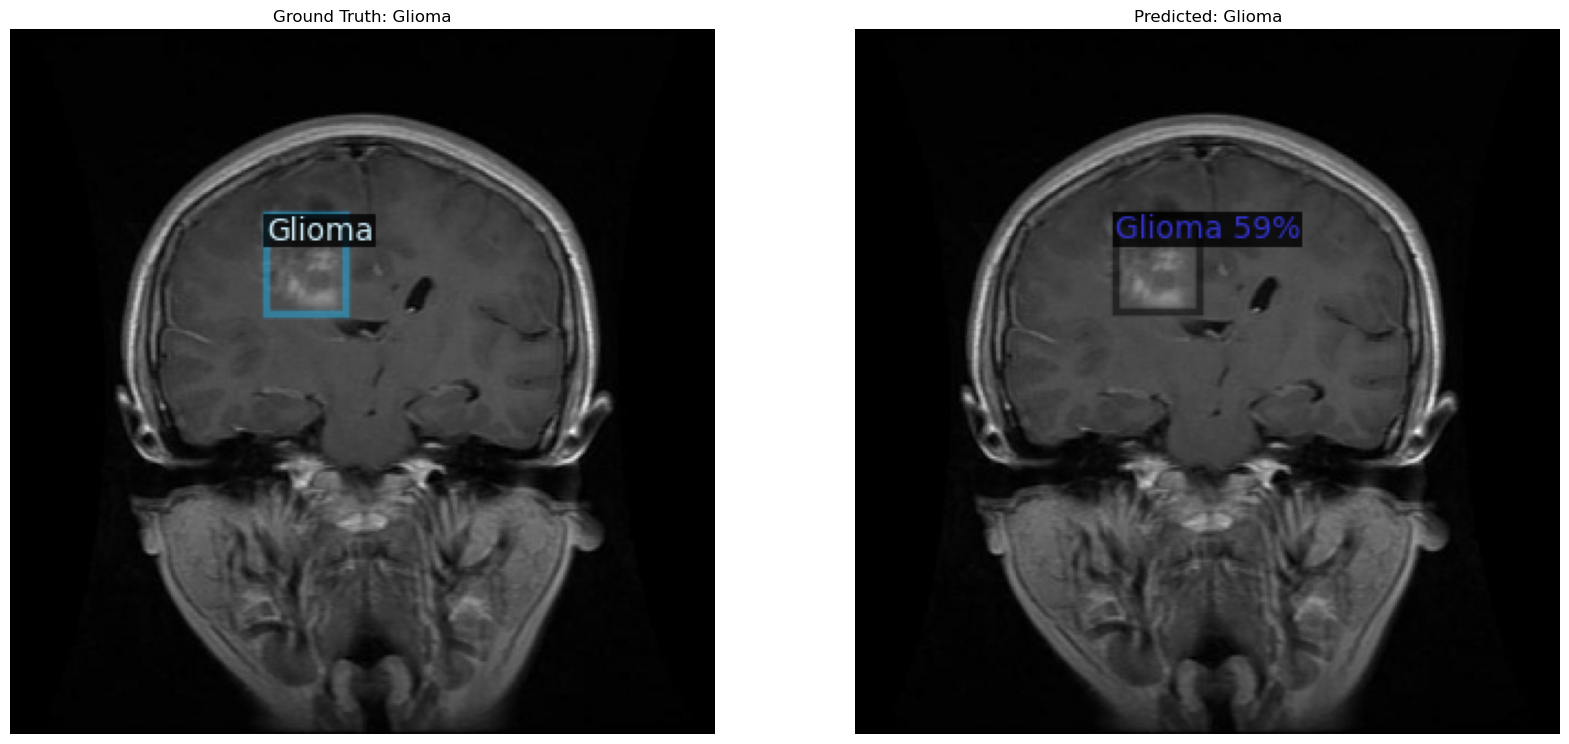

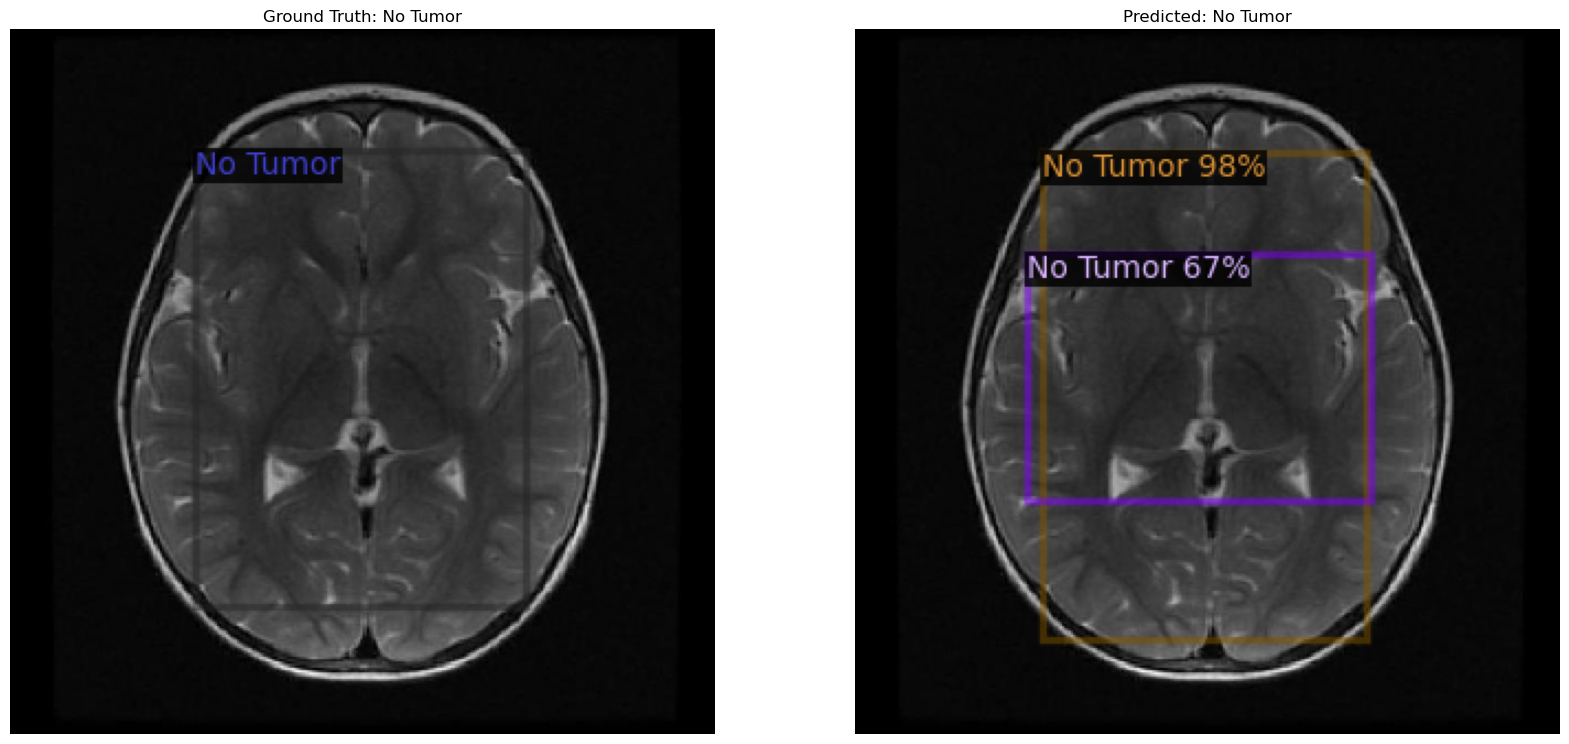

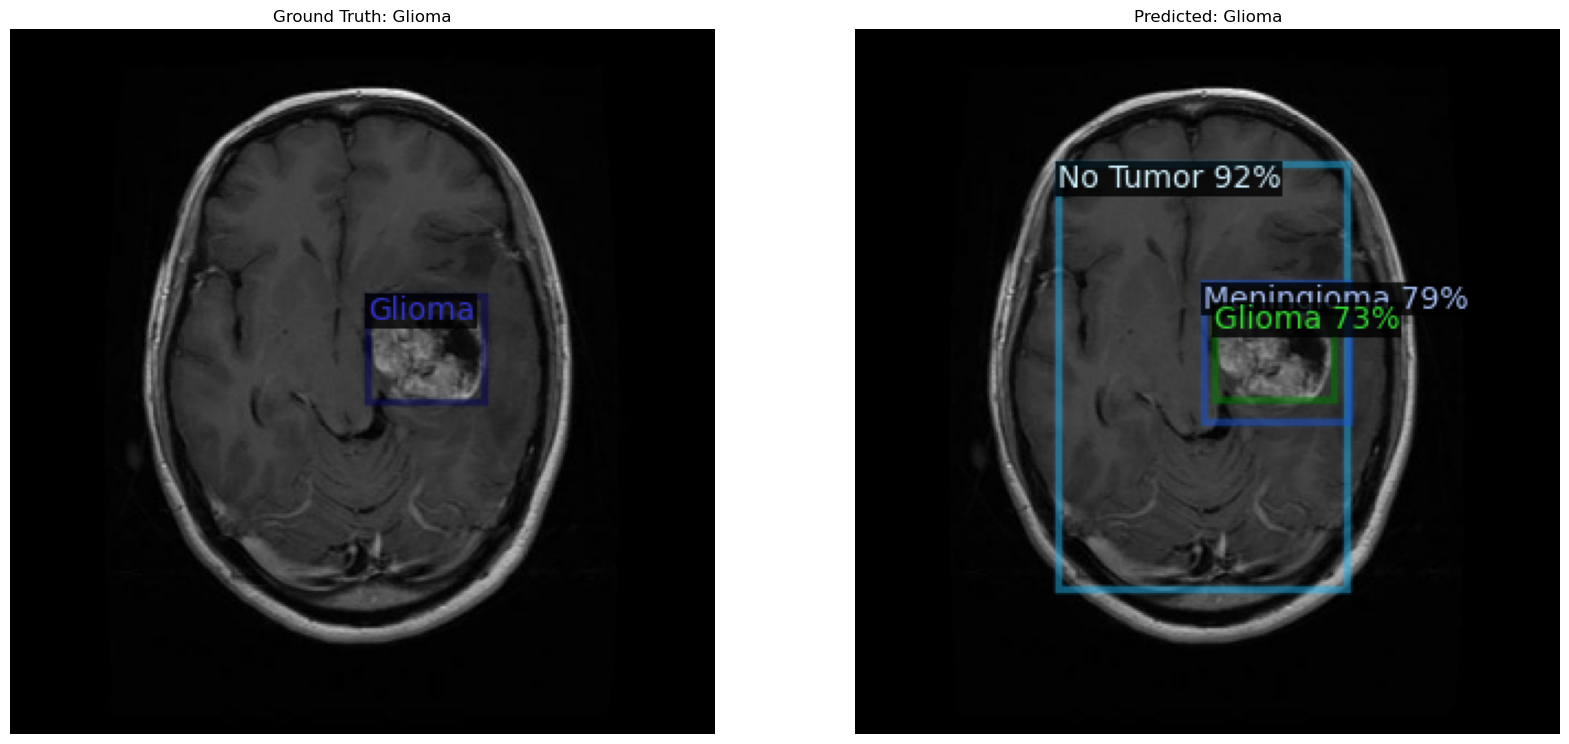

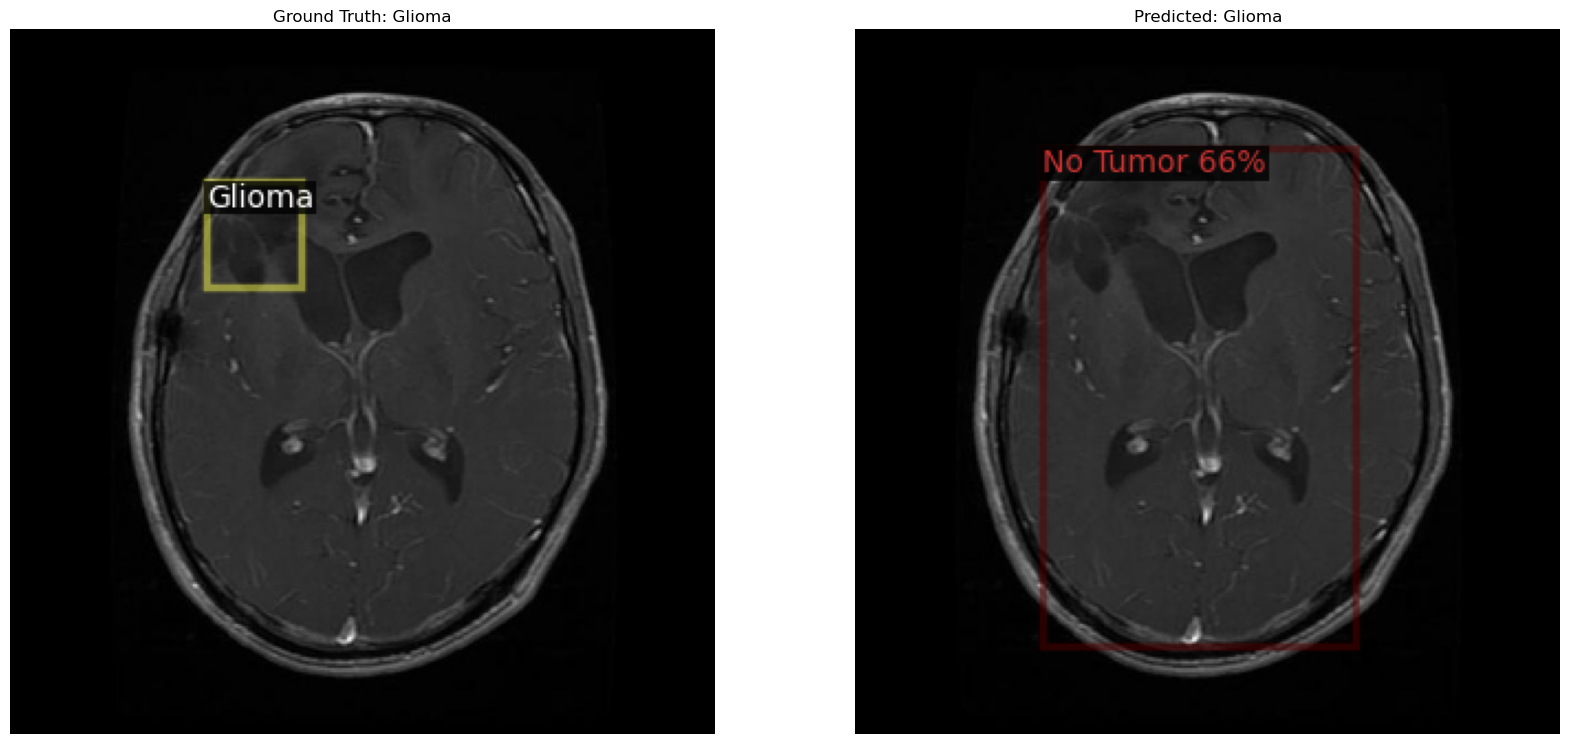

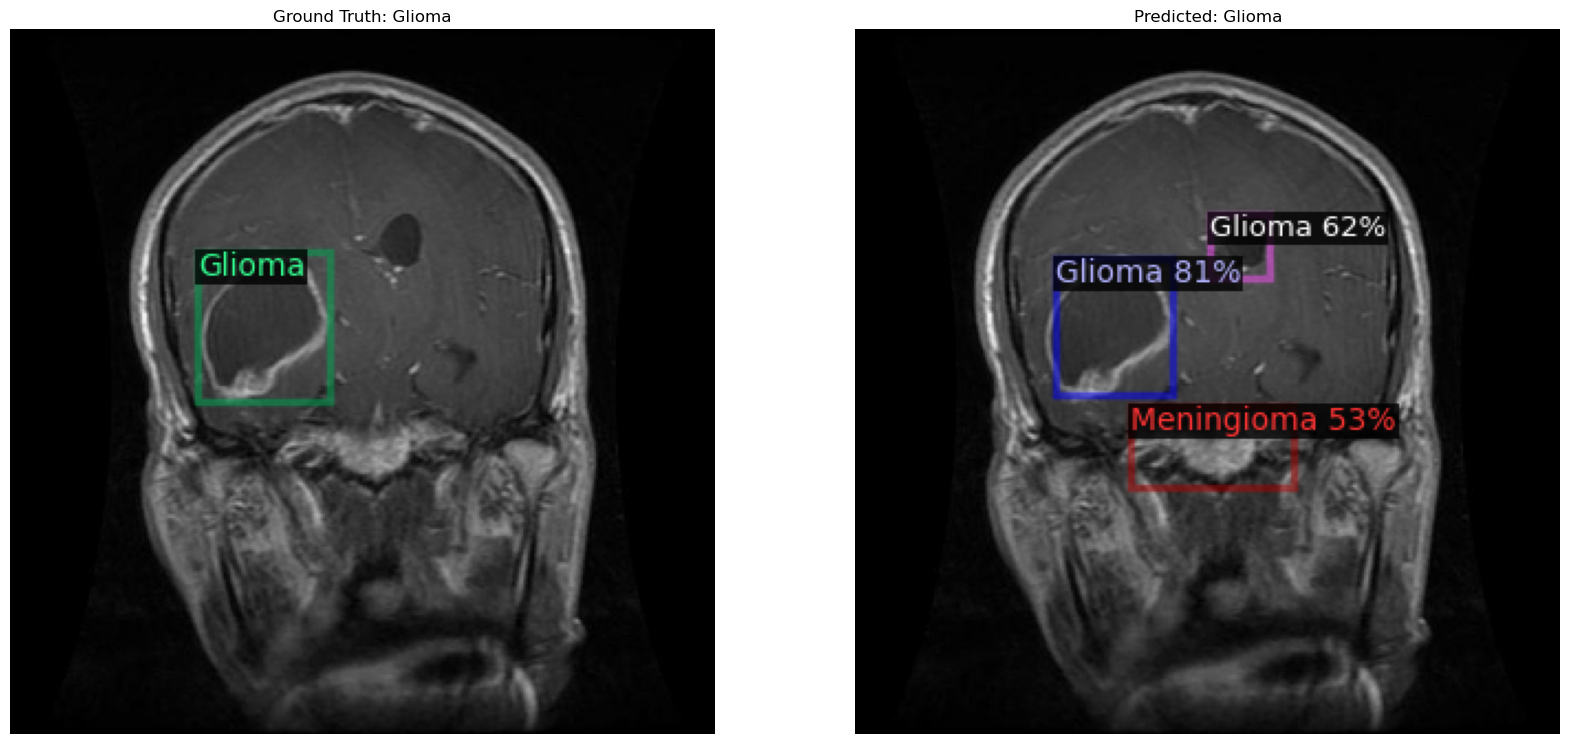

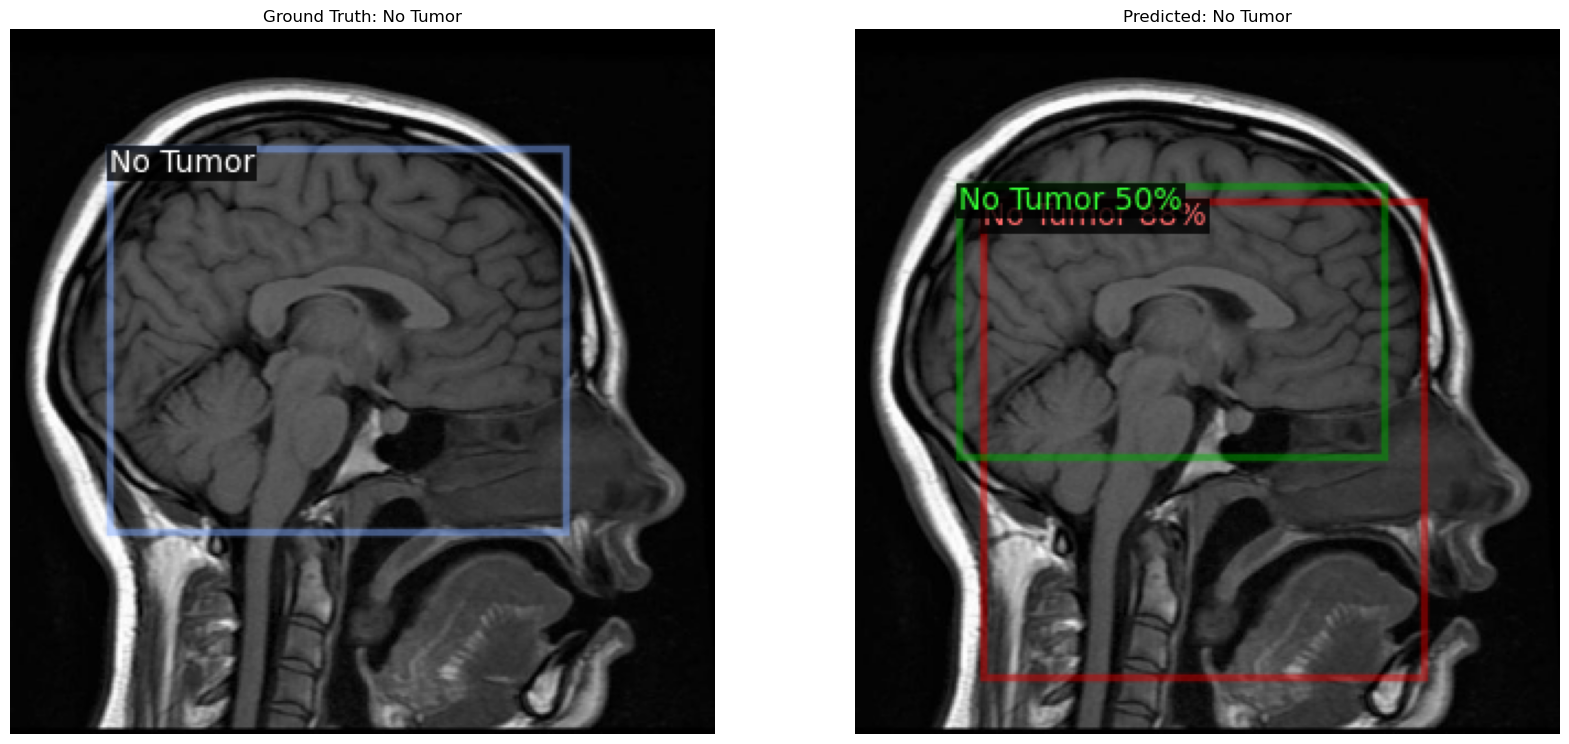

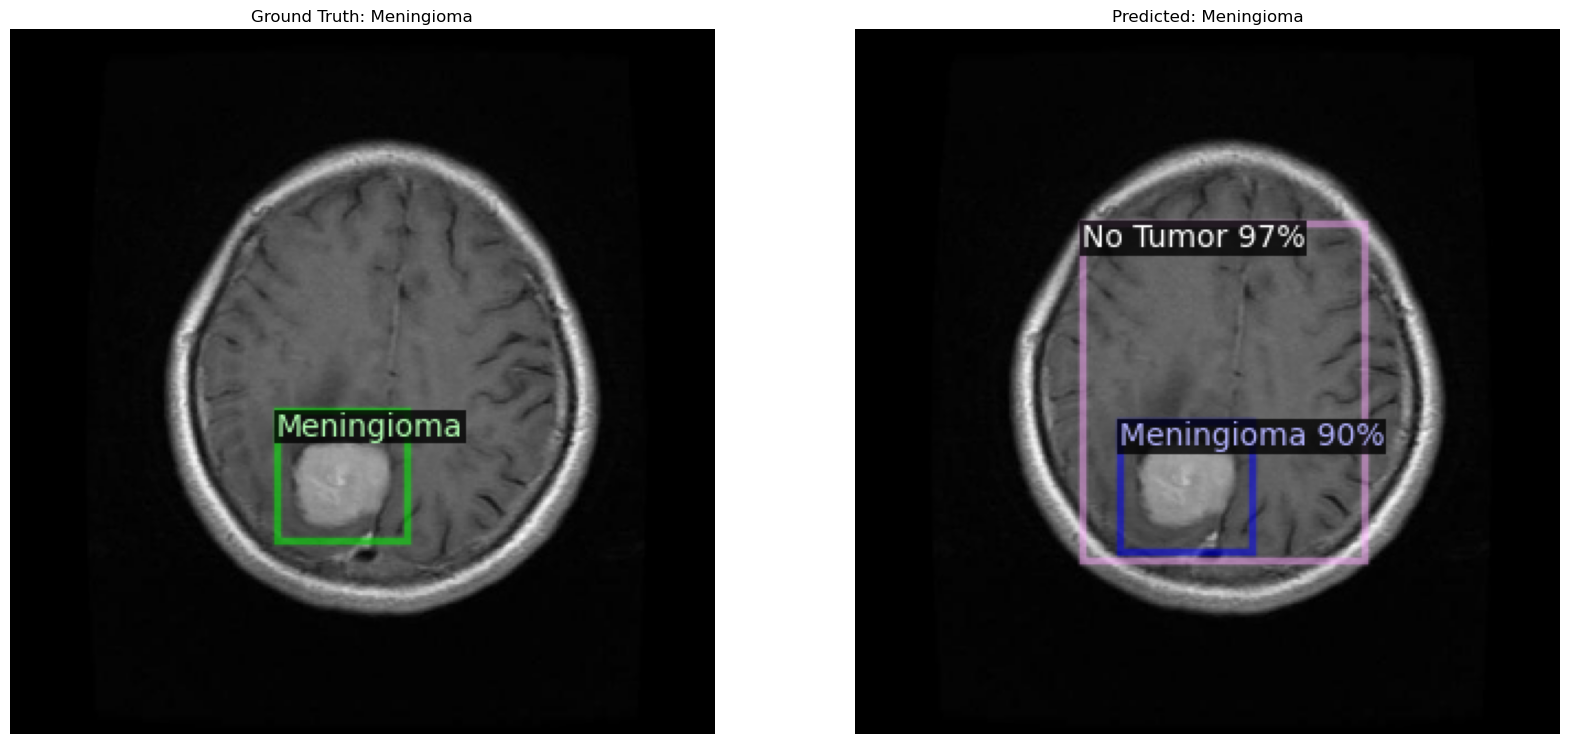

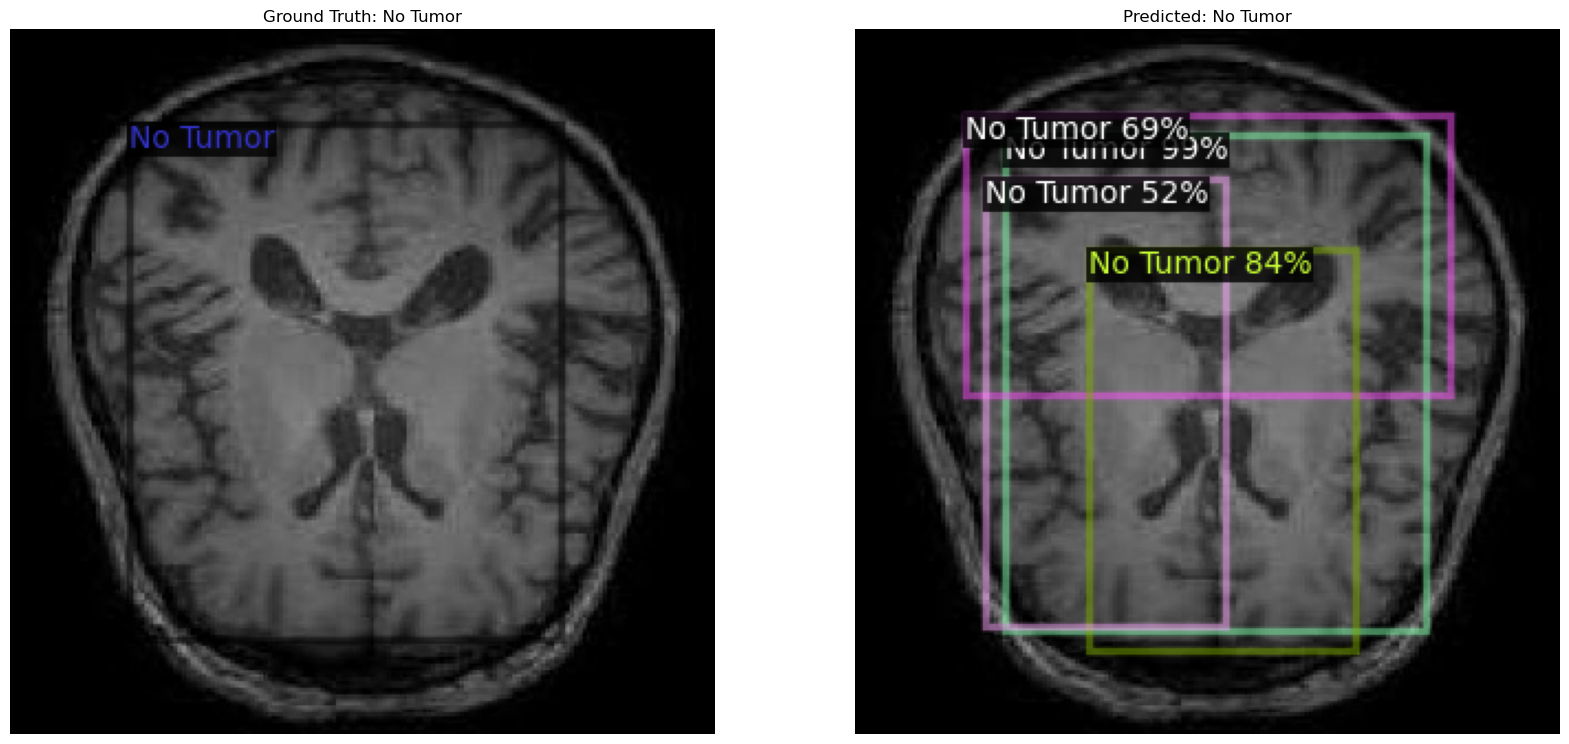

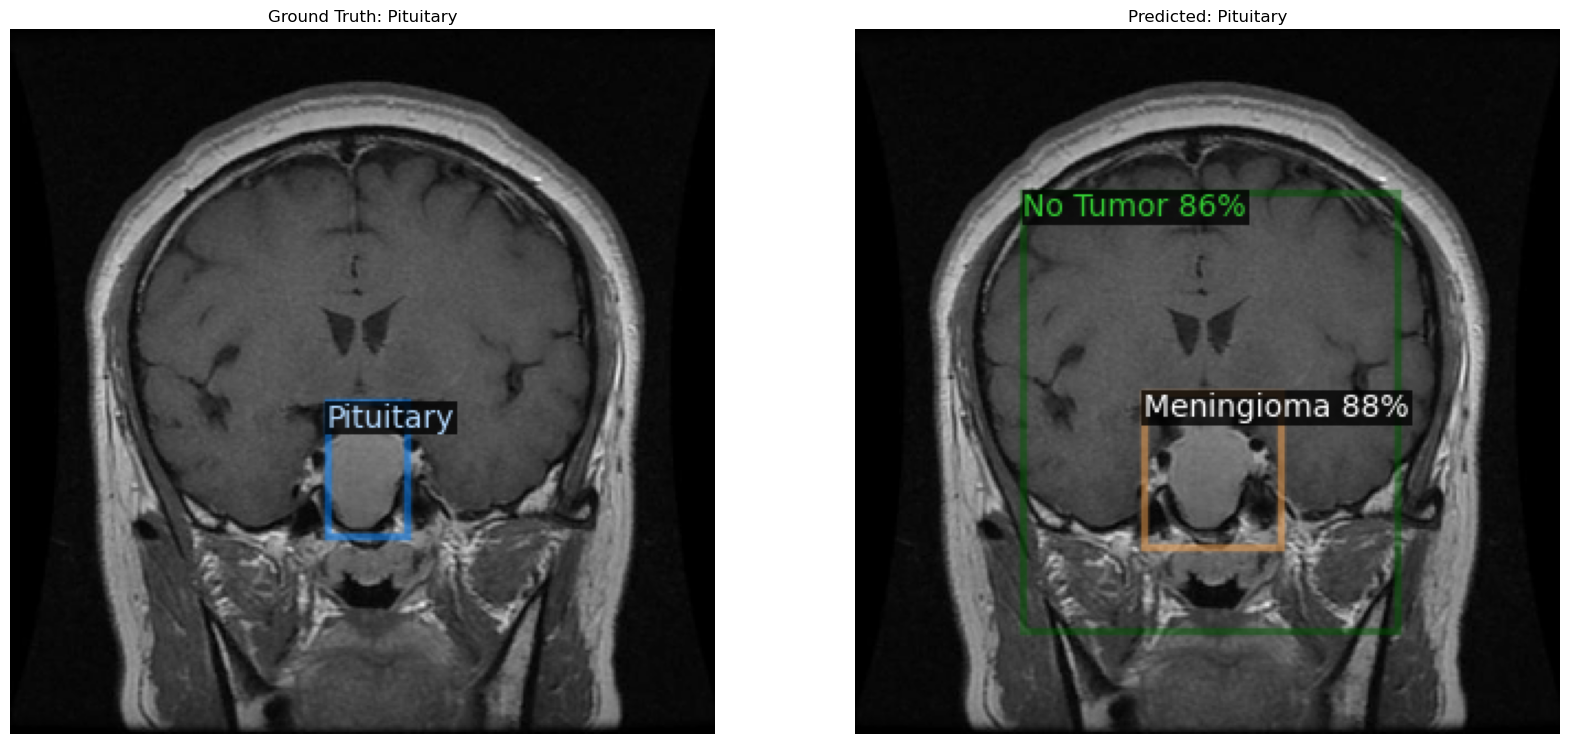

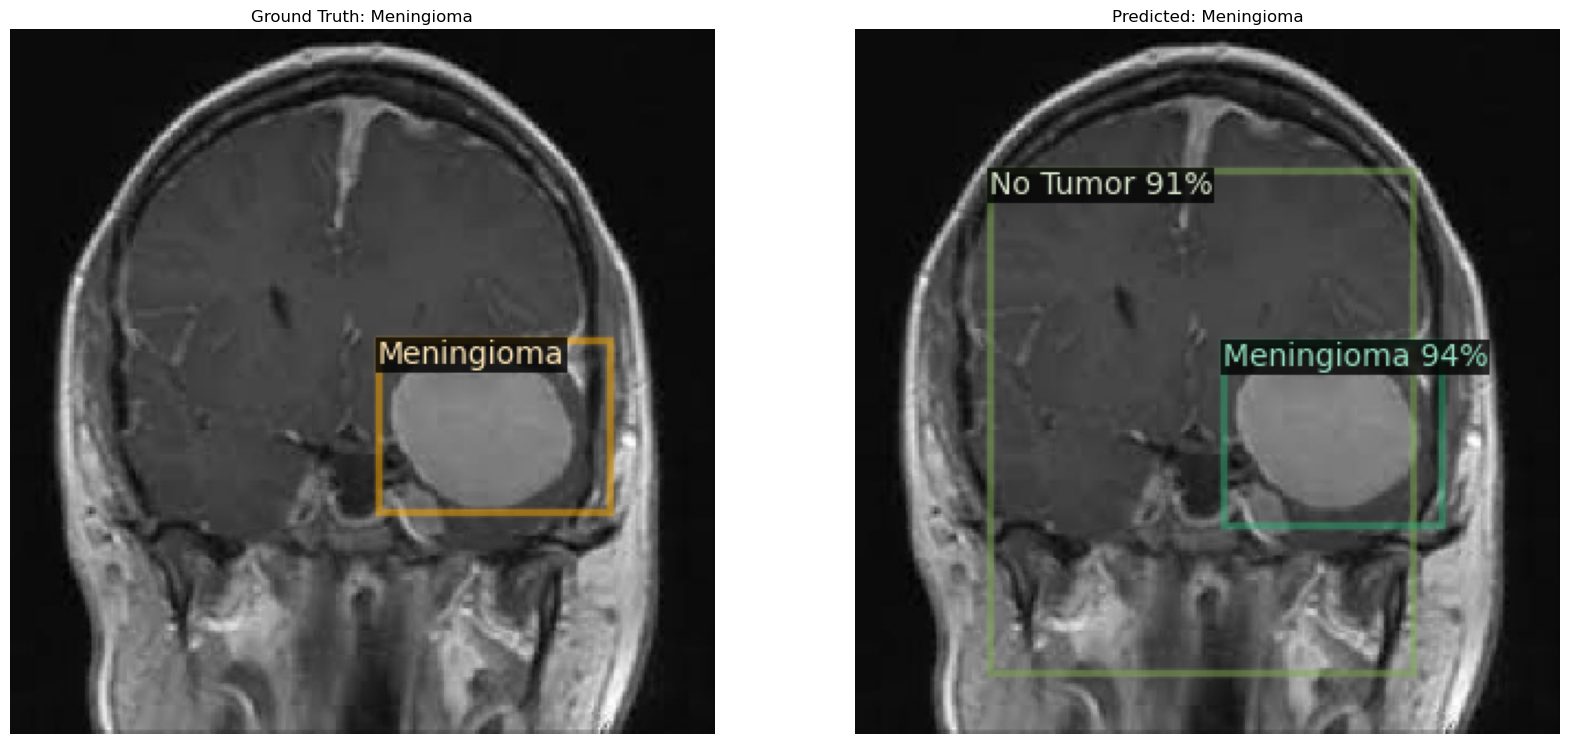

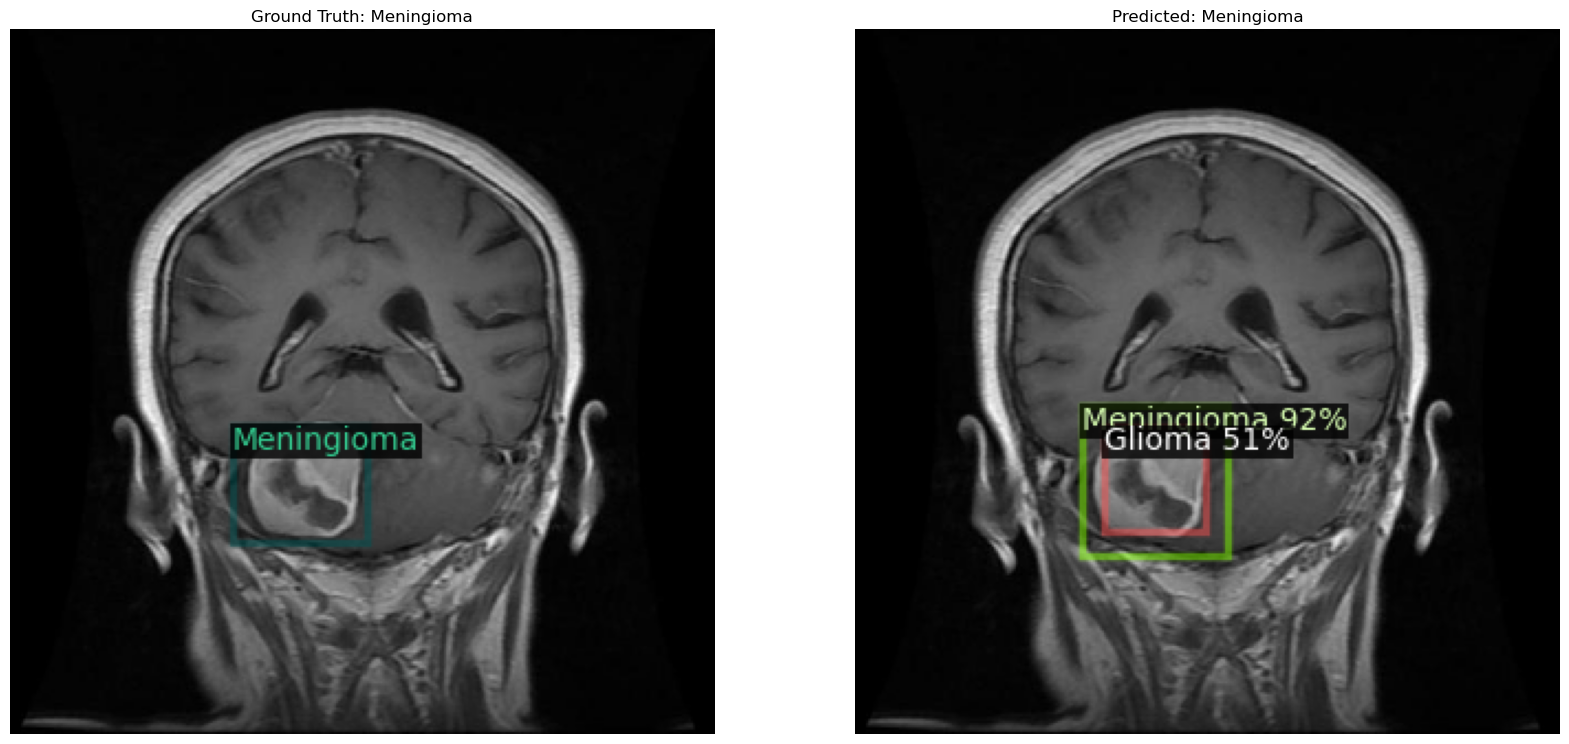

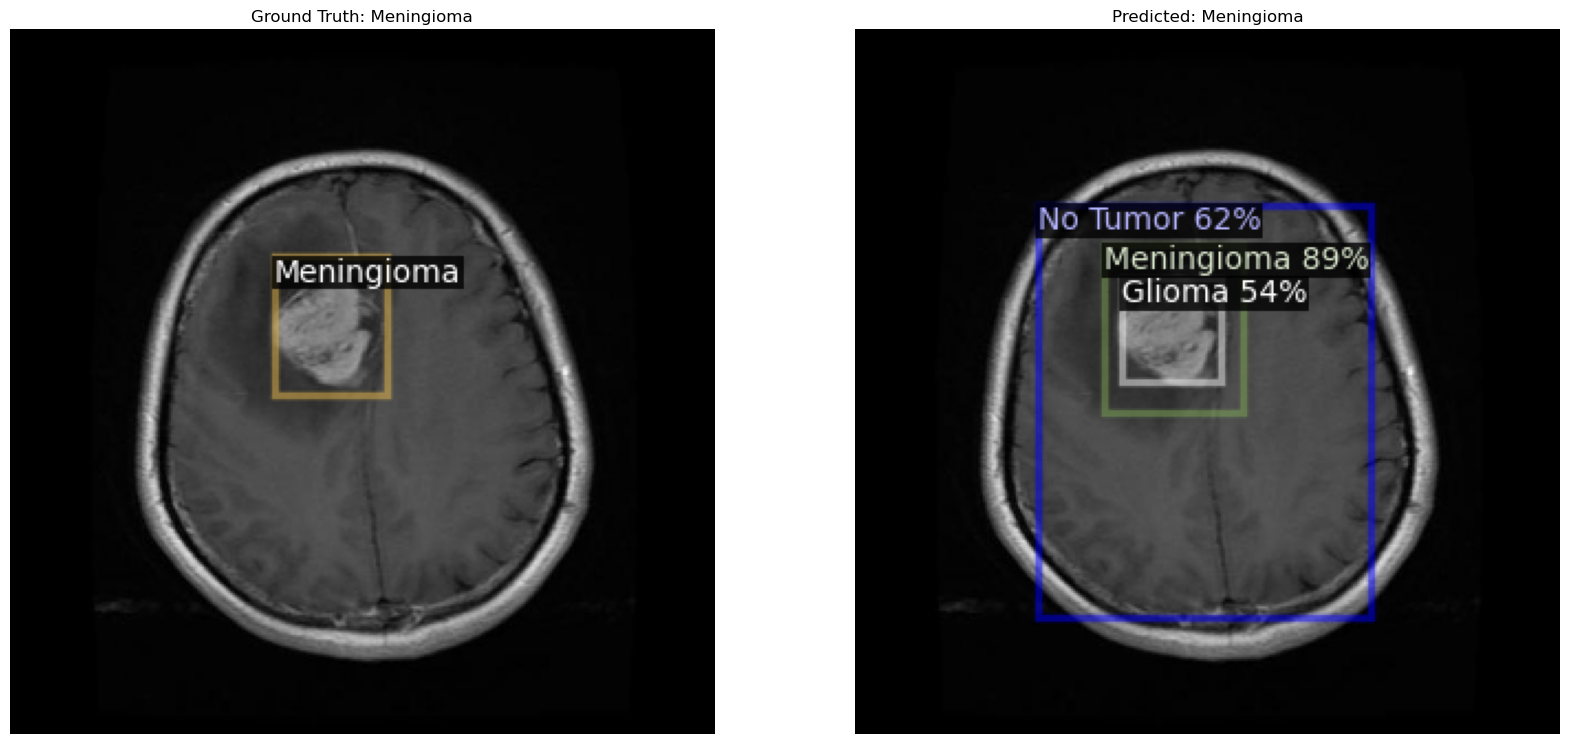

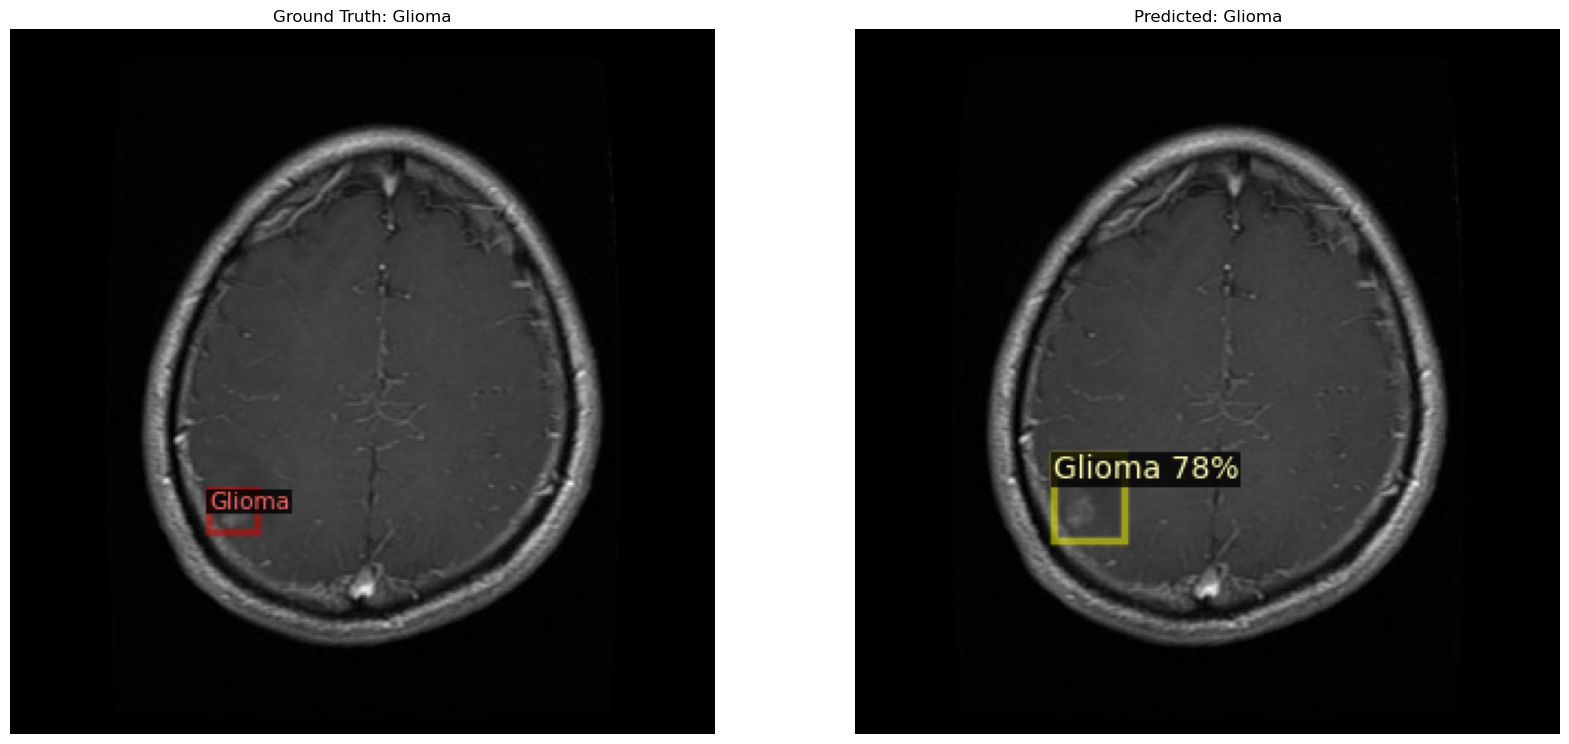

In [12]:
def get_class_name_from_filename(filename):
    if 'Tr-gl' in filename:
        return 'Glioma'
    elif 'Tr-me' in filename:
        return 'Meningioma'
    elif 'Tr-pi' in filename:
        return 'Pituitary'
    elif 'Tr-no' in filename:
        return 'No Tumor'
    else:
        return 'Unknown'

# Inference with the trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

# Make sure to register your dataset's metadata beforehand
# Here it's assumed you have a metadata variable set up for the validation dataset
dataset_dicts = DatasetCatalog.get("my_dataset_val")
metadata = MetadataCatalog.get("my_dataset_val")

sampled_dicts = random.sample(dataset_dicts, min(len(dataset_dicts), 20))
for d in sampled_dicts:  # Change the number as needed
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im.copy(), metadata=metadata, scale=0.5)
    out_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    class_name_pred = get_class_name_from_filename(d["file_name"])

    # Draw ground truth on the original image
    v = Visualizer(im.copy(), metadata=metadata, scale=0.5)
    out_gt = v.draw_dataset_dict(d)
    class_name_gt = get_class_name_from_filename(d["file_name"])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(out_gt.get_image()[:, :, ::-1])
    ax1.set_title(f"Ground Truth: {class_name_gt}")
    ax1.axis('off')

    ax2.imshow(out_pred.get_image()[:, :, ::-1])
    ax2.set_title(f"Predicted: {class_name_pred}")
    ax2.axis('off')
    plt.show()